## This notebook is for the exploration of a new subset of AwanTunai's data that has less abnormality. The goal is to clean and prep the data, and develop an initial model that helps answer a business question of my choosing.

First, basic data prep

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
baskets = pd.read_csv('new_baskets_adhie.csv')

In [3]:
from math import floor
def prep_data(filename, dropna,datecol):
    baskets = pd.read_csv(filename, parse_dates = [datecol])
    if dropna:
        baskets.dropna(inplace=True)
    for s in baskets.columns:
        if ("id" in s):
            baskets.loc[:,s] = pd.Categorical(baskets.loc[:,s].apply(lambda x: floor(x)))
    if datecol:
        baskets['date'] = baskets[datecol].dt.date
        baskets['year'] = baskets[datecol].dt.year
        baskets['month'] = baskets[datecol].dt.month
        baskets['day'] = baskets[datecol].dt.day
        baskets['hour'] = baskets[datecol].dt.hour
        baskets['weekday'] = baskets[datecol].dt.weekday
        baskets["spent"] = baskets["qty"] * baskets["price"]
    return baskets

def make_merchants(baskets):
    merchants = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat_id','nunique'), 
        num_sub_cats = ('sub_cat_id','nunique'),
    ).reset_index()
    merchants['avg_spent_per_order'] = merchants.total_spent / merchants.num_orders
    return merchants

def make_skus(baskets):
    skus_by_day = baskets.groupby(['sku_id','date']).agg(
        avg_price_by_day = ('price','mean'),
        num_order_by_day = ('order_id', 'nunique'), 
        num_merchants_by_day = ('merchant_id', 'nunique'),
    ).reset_index()
    return skus_by_day

def make_top_cats(baskets):
    top_cats = baskets.groupby(['top_cat_id']).agg(
        avg_price = ('price', 'mean'),
        total_spent = ('spent', 'sum'),
        total_quantity = ('qty' , 'sum'),
        num_orders = ('order_id', 'nunique'), 
        num_days = ('date' , 'nunique'),
        num_merchants = ('merchant_id', 'nunique')
    ).reset_index()
    return top_cats

In [4]:
dropna = True
datecol = 'placed_at'
filename = 'new_baskets_adhie.csv'

baskets = prep_data(filename, dropna,datecol)
merchants = make_merchants(baskets)
skus = make_skus(baskets)
top_cats = make_top_cats(baskets)

In [5]:
baskets.head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent
0,1,1,2021-06-17 14:00:31.373,9,10,27,86,2,343000.0,2021-06-17,2021,6,17,14,3,686000.0
1,2,1,2021-06-17 14:00:31.373,9,6,27,86,1,159000.0,2021-06-17,2021,6,17,14,3,159000.0
2,3,1,2021-06-17 14:00:31.373,9,14,27,86,2,225000.0,2021-06-17,2021,6,17,14,3,450000.0
3,4,1,2021-06-17 14:00:31.373,9,5,27,86,1,246000.0,2021-06-17,2021,6,17,14,3,246000.0
4,5,2,2021-06-17 14:29:31.918,10,15,27,86,5,19500.0,2021-06-17,2021,6,17,14,3,97500.0


In [6]:
merchants.head(40)

,merchant_id,total_spent,num_orders,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order
0,1,1.180240e+07,11,8,52,12,19,1.072945e+06
1,2,1.503500e+07,8,8,49,13,21,1.879375e+06
2,3,3.805570e+07,37,26,145,24,43,1.028532e+06
3,4,1.021000e+06,2,2,9,5,5,5.105000e+05
4,5,2.688000e+06,2,2,20,7,9,1.344000e+06
5,6,1.195500e+06,2,2,19,7,9,5.977500e+05
6,7,1.830000e+04,1,1,1,1,1,1.830000e+04
7,8,9.600000e+04,1,1,1,1,1,9.600000e+04
8,9,1.832620e+07,11,11,44,12,16,1.666018e+06
9,10,1.946100e+06,2,2,38,12,20,9.730500e+05


What is my question?
- Profiling merchants by SKU groups? Top_Cat groups?
- Clustering merchants according to certain statistics, finding which has the most intercluster similarity and least intracluster similarity
- Visualizing which top_cats are related to each other
- Which top_cats are more often bought together? 


Basket recommendation? 

Deliver clustering on merchants to differentiate

Cluster by something with SKUs in merchant (Top Cat)

Find top cats for each merchant, adjacent categories/ expensive vs not expensive categories

Build additional features for clustering

Google collab

#### Now prep the data for my clustering specifically: Want to cluster by merchant value (high, medium, low) and sku top_cat types?

What rows do I want to use in clustering? Create that dataframe for merchants, then for merchants vs sku and cat types
- top_cat overall for each merchant
(baskets.query('merchant_id == merch_id).query(...))

In [7]:
temp = baskets[baskets['merchant_id']==50]

In [8]:
temp.head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent
29666,29680,3246,2021-09-29 17:56:37.010,50,185,27,86,10,20000.0,2021-09-29,2021,9,29,17,2,200000.0
29667,29681,3246,2021-09-29 17:56:37.010,50,179,27,86,20,12200.0,2021-09-29,2021,9,29,17,2,244000.0
29668,29682,3246,2021-09-29 17:56:37.010,50,183,27,86,20,23950.0,2021-09-29,2021,9,29,17,2,479000.0
29669,29683,3246,2021-09-29 17:56:37.010,50,119,27,86,10,24800.0,2021-09-29,2021,9,29,17,2,248000.0
29670,29684,3246,2021-09-29 17:56:37.010,50,177,27,86,40,18200.0,2021-09-29,2021,9,29,17,2,728000.0


## Still can't quite crack this one (top_cat_id stat)- I think I should be able to get it with a little more thought this weekend

In [54]:
def findTopCat(merch_id):
    top_cats = [0]*35
    temp = baskets[baskets['merchant_id']==merch_id]
    for i in temp.index:
        print (i)
        top_cats[temp.iloc[[i,'top_cat_id']]] += temp.iloc[[i]].qty  

In [55]:
findTopCat(50)

29666


ValueError: invalid literal for int() with base 10: 'top_cat_id'

one merchant
iterate through each row for that merchant
add quantity ordered to that top_cat counter index in array
return largest index?

I'm going to run some basic clustering on the rows I already have just to make sure its working.

In [11]:
def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

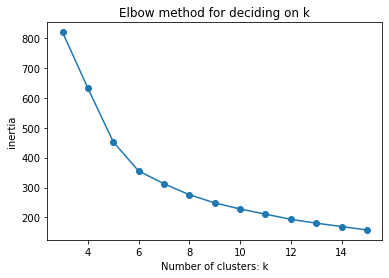

In [12]:
colnames = merchants.columns[2:]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(merchants, colnames,clusters_range)

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

colnames = merchants.columns[2:]
k = 6
merchants_kmeans = run_kmeans(merchants, colnames,k)
merchants_kmeans.groupby("cluster").size()

cluster
0    106
1    104
2      1
3     10
4     35
5     73
dtype: int64

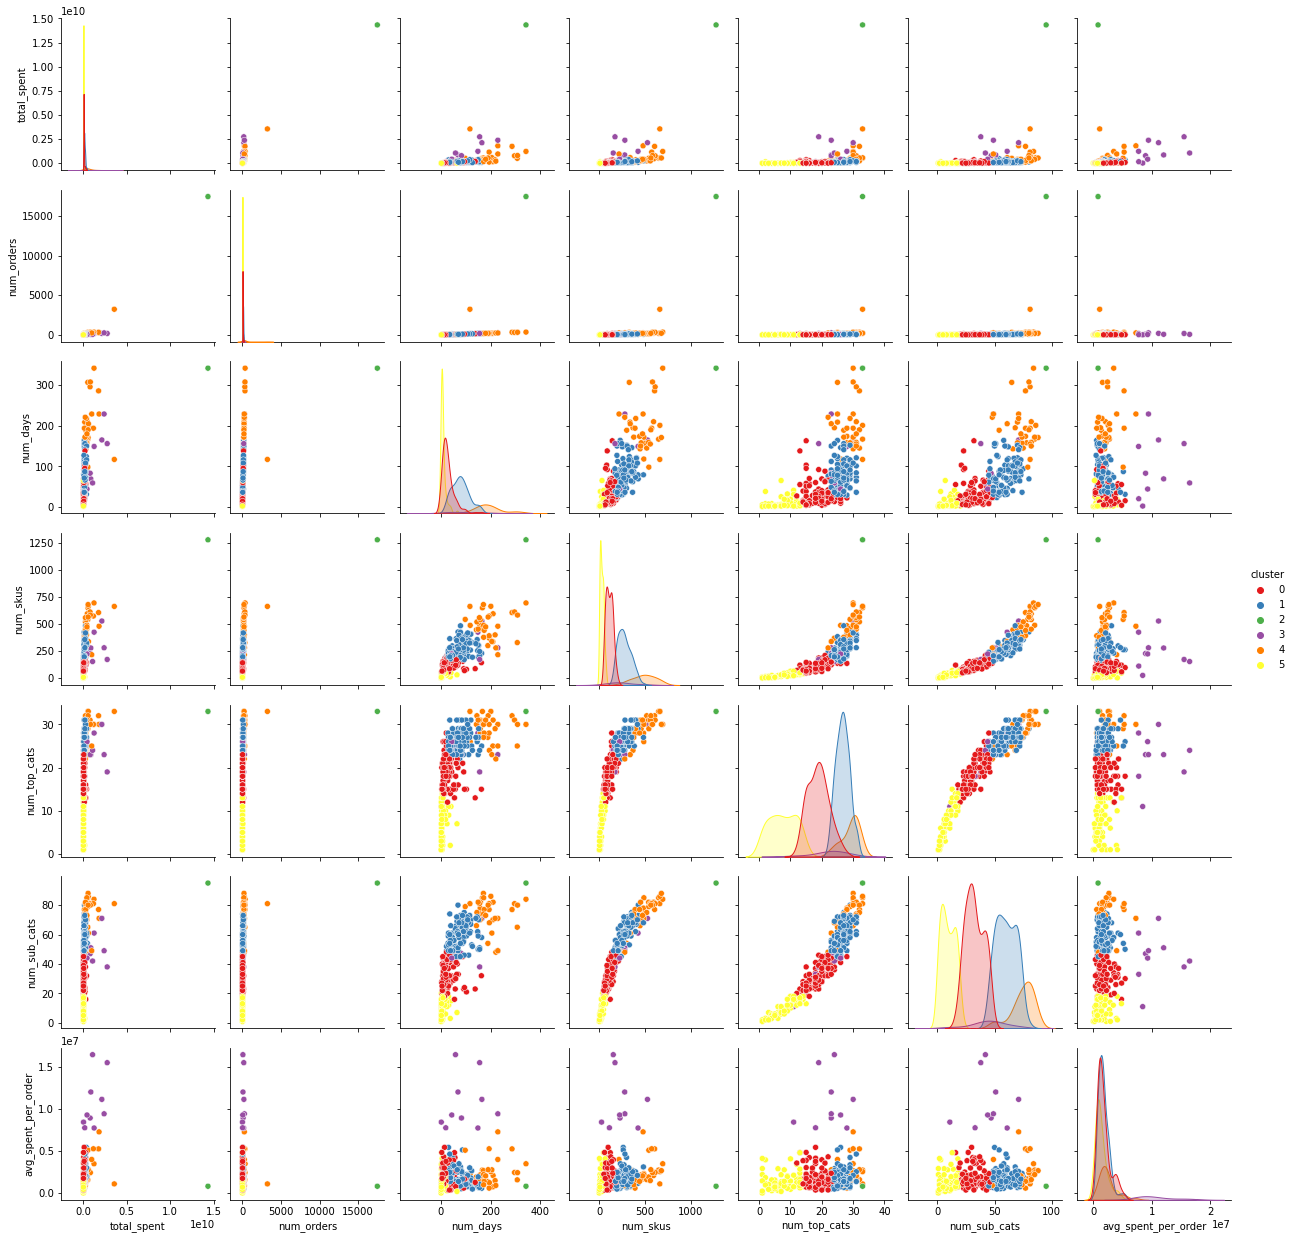

In [14]:
sns.pairplot(data=merchants_kmeans, hue="cluster", palette="Set1")

## Two new features

In [15]:
merchants['avg_spent_per_day'] = merchants['total_spent']/merchants['num_days']

In [16]:
merchants.head()

,merchant_id,total_spent,num_orders,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,cluster,avg_spent_per_day
0,1,11802400.0,11,8,52,12,19,1.072945e+06,5,1.475300e+06
1,2,15035000.0,8,8,49,13,21,1.879375e+06,5,1.879375e+06
2,3,38055700.0,37,26,145,24,43,1.028532e+06,0,1.463681e+06
3,4,1021000.0,2,2,9,5,5,5.105000e+05,5,5.105000e+05
4,5,2688000.0,2,2,20,7,9,1.344000e+06,5,1.344000e+06


In [17]:
def makeMaxVal(merch_id, col):
    temp = baskets[baskets['merchant_id'] == merch_id]
    return temp[col].max()

In [18]:
print (makeMaxVal(50, 'price'))

575000.0


In [22]:
merchants['max_price'] = 0
for i in merchants.index:
    merchants.loc[i,'max_price'] = makeMaxVal(i, 'price')

In [23]:
merchants.head()

,merchant_id,total_spent,num_orders,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,cluster,avg_spent_per_day,max_price
0,1,11802400.0,11,8,52,12,19,1.072945e+06,5,1.475300e+06,NaN
1,2,15035000.0,8,8,49,13,21,1.879375e+06,5,1.879375e+06,381000.0
2,3,38055700.0,37,26,145,24,43,1.028532e+06,0,1.463681e+06,3710000.0
3,4,1021000.0,2,2,9,5,5,5.105000e+05,5,5.105000e+05,3620000.0
4,5,2688000.0,2,2,20,7,9,1.344000e+06,5,1.344000e+06,132000.0


Now that I've made two new features that could offer some insights, I'm going to re-run the clustering.

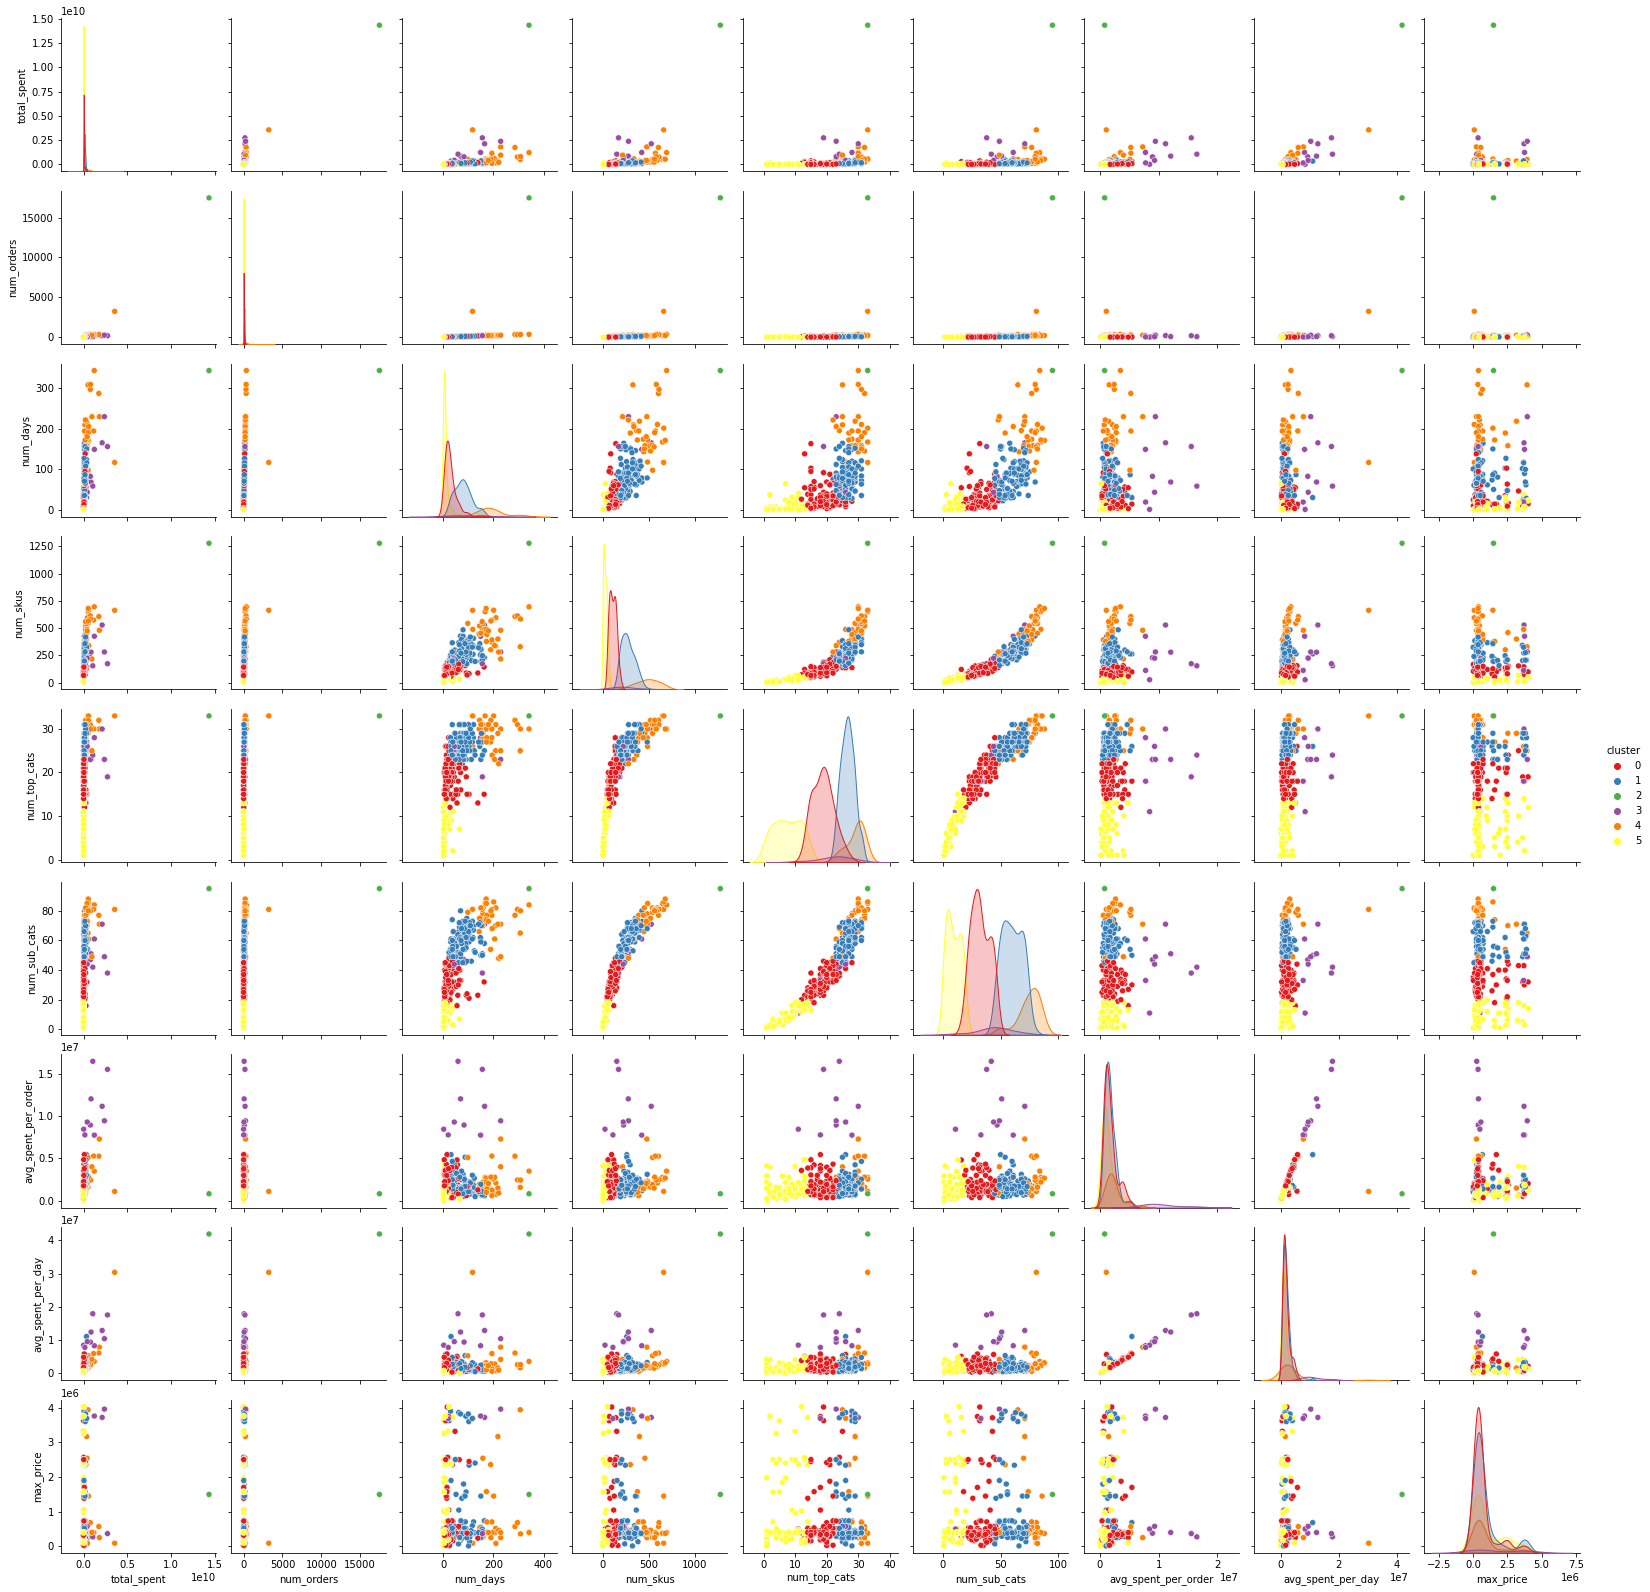

In [24]:
sns.pairplot(data=merchants_kmeans, hue="cluster", palette="Set1")